# 1. Import and Install Dependencies

In [2]:
%pip install opencv-python mediapipe scikit-learn matplotlib

     ---------------------------------------- 0.0/199.7 kB ? eta -:--:--
     -------------------------------------- 199.7/199.7 kB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/42.2 MB ? eta -:--:--
      --------------------------------------- 0.7/42.2 MB 13.9 MB/s eta 0:00:03
     - -------------------------------------- 2.0/42.2 MB 11.6 MB/s eta 0:00:04
     -- ------------------------------------- 2.6/42.2 MB 11.6 MB/s eta 0:00:04
     --- ------------------------------------ 3.3/42.2 MB 11.7 MB/s eta 0:00:04
     --- ------------------------------------ 4.0/42.2 MB 11.1 MB/s eta 0:00:04
     ---- ----------------------------------- 4.4/42.2 MB 10.9 MB/s eta 0:00:04
     ---- ----------------------------------- 4.9/42.2 MB 11.2 MB/s eta 0:00:04
     ----- ---------------------------------- 5.4/42.2 MB 10.8 MB/s eta 0:00:04
     ----- ---------------------------------- 6.0/42.2 MB 11.2 MB/s eta 0:00:04
     ------ --------------------------------- 6.7/42.2 

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 23.5.26 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.24.4 which is incompatible.


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 


In [64]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [37]:
draw_landmarks(frame, results)

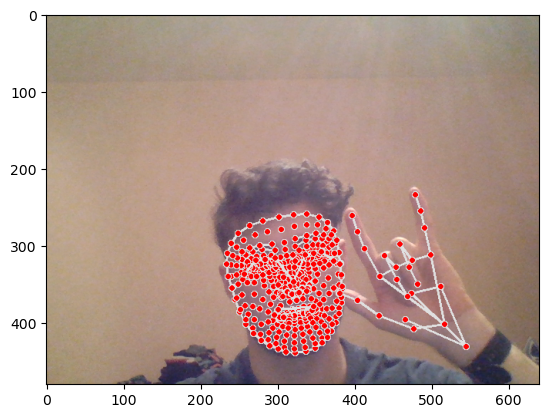

In [38]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [39]:
len(results.left_hand_landmarks.landmark)

21

In [40]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [41]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [47]:
print(pose.shape, face.shape, lh.shape, rh.shape)

(132,) (1404,) (63,) (63,)


In [42]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [43]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [44]:
result_test = extract_keypoints(results)

In [46]:
print(result_test.shape)

(1662,)


In [18]:
np.save('0', result_test)

In [19]:
np.load('0.npy')

array([ 0.47623053,  0.60170281, -1.2480557 , ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [11]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 


# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou','nogesture'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Data') 


# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou','nogesture'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

In [3]:
# Obtenez le répertoire de travail actuel
current_directory = os.getcwd()

# Affichez le répertoire de travail actuel
print("Répertoire de travail actuel :", current_directory)

Répertoire de travail actuel : c:\Users\l3ics\OneDrive\Bureau\sign_language_detection


In [17]:
# initialisation du répertoire
for action in actions: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [8]:
# Add new folders if needed
for action in actions:
    dir_path = os.path.join(DATA_PATH, action)
    
    # Check if the directory is empty
    if not DATA_PATH in os.listdir() :
        # Directory is empty, handle it as needed
        print(f"The directory {DATA_PATH} is empty.")
        # Your code to handle an empty directory goes here
    else:
        # Directory is not empty, proceed with creating new directories
        dirmax = np.max(np.array(os.listdir(dir_path)).astype(int))
        for sequence in range(1, no_sequences + 1):
            try:
                os.makedirs(os.path.join(dir_path, str(dirmax + sequence)))
            except:
                # Handle the exception as needed
                pass


# 5. Collect Keypoint Values for Training and Testing

In [8]:
# vérifier si les repertoires ont été créés, déterminer le premier répertoire vide pour initialiser la variable start_folder
# le nombre d'acquisitions doit être variabiliser en fonction du nombre de répertoires créés

# Check if the directory is empty
if not DATA_PATH in os.listdir() :
    # Directory is empty, handle it as needed
    print(f"The directory {DATA_PATH} is empty.")
    # Your code to handle an empty directory goes here

if sorted(actions) != sorted(os.listdir(DATA_PATH)):
    print(f"The actions list have changed.")
    # Your code to handle an empty directory goes here

for actions in actions : 
    dir_path = os.path.join(DATA_PATH, actions)
    dirmax = np.max(np.array(os.listdir(dir_path)).astype(int))
    print(f"The directory {dir_path} have {dirmax} folders.")

############################################################################################################
# CONTINUE FROM HERE
############################################################################################################


The directory MP_Data\hello have 120 folders.
The directory MP_Data\thanks have 120 folders.
The directory MP_Data\iloveyou have 120 folders.
The directory MP_Data\nogesture have 120 folders.


In [60]:
start_folder = 121
no_sequences = 5

In [58]:
print(actions[0], actions[1], actions[2], actions[3])
print(str(start_folder))

hello thanks iloveyou nogesture
91


In [22]:
npy_path = os.path.join(DATA_PATH, actions[1], str(1), str(1))
np.save(npy_path, result_test)

In [61]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        
        for sequence in range(start_folder, start_folder+no_sequences):
            sign = np.zeros((1662,30))
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW
                    
                sign[:,frame_num] = extract_keypoints(results)
                # NEW Export keypoints
                #keypoints = extract_keypoints(results)
                #npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                #np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            npy_path = os.path.join(DATA_PATH, action, str(sequence))
            np.save(npy_path, sign)
    start_folder += no_sequences
    cap.release()
    cv2.destroyAllWindows()

In [13]:
start_folder

1

In [158]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [53]:
label_map = {label:num for num, label in enumerate(actions)}

In [54]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2, 'nogesture': 3}

In [79]:
sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)

    for sequence in np.array(os.listdir(action_path)).astype(int):
        sequence_path = os.path.join(action_path, str(sequence))
        
        window = []
        for frame_num in range(sequence_length):
            file_path = os.path.join(sequence_path, "{}.npy".format(frame_num))
            
            # Vérifiez si le fichier existe avant de le charger
            if os.path.exists(file_path):
                res = np.load(file_path)
                window.append(res)
            else:
                #print(f"Le fichier {file_path} n'existe pas. Ignorer cette séquence.")
                break  # Arrête la boucle si un fichier est manquant
        
        # Ajoutez la séquence uniquement si tous les fichiers existent
        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[action])


On refait le code prédent, en supposant que nos dossiers sont organisés de la façon suivante, 4 dossiers actions et dans chacun les n sequences de 30 frame de 1662 landmarks.

In [ ]:
sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)

    for sequence in np.array(os.listdir(action_path)).astype(int):
        sequence_path = os.path.join(action_path, "{}.npy".format(sequence))
        window = []
        # Vérifiez si le fichier existe avant de le charger
        if os.path.exists(sequence_path):
            res = np.load(sequence_path)
            window.append(res)
        else:
            #print(f"Le fichier {file_path} n'existe pas. Ignorer cette séquence.")
            break  # Arrête la boucle si un fichier est manquant
    

In [62]:
print(np.array(sequences).shape, np.array(labels).shape)

(480, 30, 1662) (480,)


In [63]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X.shape

(480, 30, 1662)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(24, 4)

# 7. Build and Train LSTM Neural Network

In [101]:
np.__version__

'1.26.0'

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


In [102]:
tf.__version__

'2.8.0'

In [26]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [49]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [50]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
15/15 [==============================] - 1s 79ms/step - loss: 0.6959 - categorical_accuracy: 0.7105
Epoch 2/1000
15/15 [==============================] - 1s 74ms/step - loss: 0.7402 - categorical_accuracy: 0.6908
Epoch 3/1000
15/15 [==============================] - 1s 71ms/step - loss: 0.6918 - categorical_accuracy: 0.7061
Epoch 4/1000
15/15 [==============================] - 1s 73ms/step - loss: 0.6418 - categorical_accuracy: 0.7522
Epoch 5/1000
15/15 [==============================] - 1s 71ms/step - loss: 0.5967 - categorical_accuracy: 0.7610
Epoch 6/1000
15/15 [==============================] - 1s 71ms/step - loss: 0.5902 - categorical_accuracy: 0.7719
Epoch 7/1000
15/15 [==============================] - 1s 71ms/step - loss: 0.7167 - categorical_accuracy: 0.6754
Epoch 8/1000
15/15 [==============================] - 1s 74ms/step - loss: 0.8114 - categorical_accuracy: 0.6469
Epoch 9/1000
15/15 [==============================] - 1s 74ms/step - loss: 0.7191 - categorical_

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-trai

# 8. Make Predictions

In [47]:
res = model.predict(X_test)

In [48]:
print(type(res))
print(res)

<class 'numpy.ndarray'>
[[0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]
 [0.33970398 0.33864686 0.3216491 ]]


In [61]:
actions[np.argmax(res[4])]

'iloveyou'

In [62]:
actions[np.argmax(y_test[4])]

'iloveyou'

In [39]:
os.getcwd()

'c:\\Users\\l3ics\\SDI\\PDI'

# 9. Save Weights

In [31]:
# Définir le chemin du répertoire des poids
weights_dir = "Weights"

# Assurez-vous que le répertoire existe, sinon, créez-le
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Sauvegarder les poids dans le fichier 'action.h5' dans le répertoire des poids
model.save(os.path.join(weights_dir, 'action_recognition_3.h5'))

In [217]:
del model

In [52]:
model.load_weights(os.path.join(weights_dir, 'action_recognition_3.h5'))

# 10. Evaluation using Confusion Matrix and Accuracy

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [51]:
yhat = model.predict(X_test)

In [52]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [53]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 7],
        [0, 2]],

       [[7, 0],
        [2, 0]],

       [[4, 0],
        [5, 0]]], dtype=int64)

In [45]:
accuracy_score(ytrue, yhat)

0.3333333333333333

# 11. Test in Real Time

In [32]:
from scipy import stats

In [33]:
colors = [(245,117,16), (117,245,16), (16,117,245), (147, 112, 219)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [55]:
image.shape

(480, 640, 3)

In [56]:
actions.shape

(4,)

In [57]:
res.shape

(1662,)

In [58]:
colors[2]

(16, 117, 245)

In [59]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

IndexError: list index out of range

<Figure size 1800x1800 with 0 Axes>

In [56]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [79]:
def enregistrer_video(nom_dossier,mot, duree_video =2, nombre=30, largeur=1280, hauteur=720, fps=30):    
    '''
    Fonction qui capture un nombre souhaité de vidéo et les enregistre dans le dossier 'nom_dossier'.
    '''
    dossier_nom = nom_dossier
    duree_message = 3
    if not os.path.exists(dossier_nom):
        os.makedirs(dossier_nom)
    # Initialisation de la capture vidéo depuis la caméra
    capture = cv2.VideoCapture(0)  # Utilisation de la première caméra (index 0)

    # Configuration de la résolution de capture
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, largeur)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, hauteur)
    capture.set(cv2.CAP_PROP_FPS, fps)

    # Enregistrement de 30 vidéos de 2 secondes chacune
    for i in range(nombre):

        nom_fichier = f"{dossier_nom}/{mot}_{i + 1}.avi"
        sortie_video = cv2.VideoWriter(nom_fichier, cv2.VideoWriter_fourcc(*'XVID'), fps, (largeur, hauteur))

        debut_enregistrement = time.time()
        # temps que la video dure moins de 2 s on enregistre le signe
        while True:
            temps_ecoule = time.time() - debut_enregistrement
            if temps_ecoule >= duree_video:
                break
            ret, frame = capture.read()
            #Affichage de la caméra
            cv2.imshow('Enregistrement', frame)
            # Ecriture de la vidéo
            sortie_video.write(frame)
        
        time.sleep(1) 
        
        #Affichage du message d'enregistrement 
        debut_message = time.time()
        while time.time() - debut_message < duree_message:
            ret, frame = capture.read()
            cv2.putText(frame, "Enregistrement termine", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Enregistrement', frame)
        
        sortie_video.release()
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    capture.release()
    cv2.destroyAllWindows()
    print("Enregistrement des vidéos terminé.")

In [82]:
enregistrer_video(os.path.join(os.getcwd(), "Video"), "hello")

Enregistrement des vidéos terminé.


In [3]:
import os
import cv2
import time

def enregistrer_video(nom_dossier, mot, duree_video=2, nombre=30, largeur=1280, hauteur=720, fps=30):
    '''
    Fonction qui capture un nombre souhaité de vidéo et les enregistre dans le dossier 'nom_dossier'.
    '''
    dossier_nom = nom_dossier
    duree_message = 3

    if not os.path.exists(dossier_nom):
        os.makedirs(dossier_nom)

    # Initialisation de la capture vidéo depuis la caméra
    capture = cv2.VideoCapture(0)  # Utilisation de la première caméra (index 0)

    # Configuration de la résolution de capture
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, largeur)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, hauteur)
    capture.set(cv2.CAP_PROP_FPS, fps)


    # Compte à rebours de 5 secondes avant le début de l'enregistrement
    for i in range(5, 0, -1):
        ret, frame = capture.read()
        cv2.putText(frame, f"Acquisition {mot} {nombre} prises", (15,12), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"{i}...", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Enregistrement', frame)
        

    print("3. Affichage Début de l’enregistrement avec un compte à rebours")

    # Enregistrement de 30 vidéos de 2 secondes chacune
    for i in range(nombre):

        nom_fichier = f"{dossier_nom}/{mot}_{i + 1}.avi"
        # sortie_video = cv2.VideoWriter(nom_fichier, cv2.VideoWriter_fourcc(*'XVID'), fps, (largeur, hauteur))

        # Compte à rebours de 2 secondes avant le début de l'enregistrement
        for j in range(2, 0, -1):
            ret, frame = capture.read()
            cv2.putText(frame, f"Acquisition {mot} {nombre} prises", (15,12), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"{j}...", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Enregistrement', frame)
            time.sleep(1)

        debut_enregistrement = time.time()
        # tant que la vidéo dure moins de 2 s, on enregistre le signe
        while True:
            temps_ecoule = time.time() - debut_enregistrement
            if temps_ecoule >= duree_video:
                break
            ret, frame = capture.read()
            # Affichage de la caméra
            cv2.imshow('Enregistrement', frame)
            # Écriture de la vidéo
            # sortie_video.write(frame)

        # sortie_video.release()

        # Affichage du message de fin du geste pendant 1 seconde
        debut_message = time.time()
        while time.time() - debut_message < 1:
            ret, frame = capture.read()
            cv2.putText(frame, "Fin du geste", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Enregistrement', frame)

        # Affichage du message de début du nouveau geste pendant 2 secondes
        debut_nouveau_geste = time.time()
        while time.time() - debut_nouveau_geste < 2:
            ret, frame = capture.read()
            cv2.putText(frame, f"Début du nouveau geste dans {int(2 - (time.time() - debut_nouveau_geste))} seconds", 
                        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Enregistrement', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()
    print("Enregistrement des vidéos terminé.")

# Exemple d'utilisation
# enregistrer_video("dossier_videos", "Hello", duree_video=2, nombre=3, largeur=1280, hauteur=720, fps=30)



In [4]:
enregistrer_video(os.path.join(os.getcwd(), "Video"), "hello")

3. Affichage Début de l’enregistrement avec un compte à rebours
Enregistrement des vidéos terminé.


In [109]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
print("GPU available:", tf.test.is_gpu_available())

# Print additional GPU information
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Print GPU device name (if available)
if tf.test.is_gpu_available():
    print("GPU device name:", tf.test.gpu_device_name())

# Check if cuDNN is enabled
print("cuDNN enabled:", tf.test.is_built_with_cuda())

# Print additional GPU information from cuDNN
print("cuDNN version:", tf.python._pywrap_util_port.CuDNN_version())


TensorFlow version: 2.8.0
GPU available: False
GPU devices: []
cuDNN enabled: True


AttributeError: module 'tensorflow' has no attribute 'python'

In [99]:

# Check if GPU is available
gpu_available = tf.test.is_gpu_available()

if gpu_available:
    # Print cuDNN version
    print("cuDNN version:", tf.config.experimental.list_physical_devices('GPU')[0].device_config.cudnn_version)
else:
    print("No GPU available.")


No GPU available.


In [1]:
import sys
print(sys.executable)

c:\Users\l3ics\anaconda3\envs\gputest\python.exe
